This notebook uses the data produced by `0_fever_decode_wikipage_IDs_to_sentences` to train and evaluate a BERT model for textual entailment.

It uses the claim, the labels, and the *first sentence only* of the datasets generated in the mentioned notebook.

This is a **bad approach**, and we latter choose to follow a much better one.
However, I still need to document this in order to understand what I did 1y ago and why.

This version trains for 2 classes only (Supports, Refutes).

In [1]:
import numpy as np
import torch
from pandas import read_csv
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

from seaborn import displot
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [10]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'bert-base-uncased' # We could use bert-large with the new GPU from gravity. Would it perform better?
# It probably would be better to check after the whole pipeline is tested. Also it probably should not be uncased, so let's
# test that too!
BATCH_SIZE = 16
NUM_WORKERS = 2 # On gravity, we were told to use 2 workers. Perhaps because we have 2 GPUs?
DEVICE

'cuda:0'

In [3]:
df_train = read_csv('./data/train_wikidecoded.csv', encoding='UTF-8')
df_dev = read_csv('./data/shared_task_dev_wikidecoded.csv', encoding='UTF-8')
df_test = read_csv('./data/shared_task_test_wikidecoded.csv', encoding='UTF-8')

In [4]:
df_train = df_train[df_train.verifiable.apply(lambda x : x=='VERIFIABLE')].reset_index(drop=True)
df_dev = df_dev[df_dev.verifiable.apply(lambda x : x=='VERIFIABLE')].reset_index(drop=True)
# Yeah, this is Support/Refute only.

In [5]:
columns_to_keep = ['claim','first_sentence','label_numeric']
# And we also only use the first sentence. This is problematic, as it greatly reduces the variability
# of evidence-claim pairings the model could learn.

df_train = df_train[columns_to_keep]
df_dev = df_dev[columns_to_keep]

df_test, df_dev = train_test_split(df_dev, test_size=.5)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_train.shape, df_test.shape, df_dev.shape

((109810, 3), (6666, 3), (6666, 3))

In [6]:
df_train.label_numeric.value_counts()

0    80035
1    29775
Name: label_numeric, dtype: int64

In [7]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, fast=True)
# standard Bert tokenizer. don't know why we make it fast.

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

425


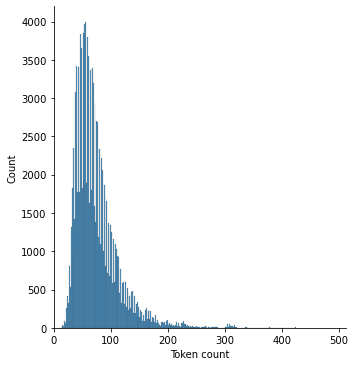

In [8]:
check_lengths = False

if check_lengths:
    # This helps see what a good max length would be
    def get_tokenized_len(row):
        tokens = tokenizer.encode(row['claim'], row['first_sentence'], max_length=512, truncation='only_second')
        return len(tokens)

    for df in [df_train, df_test, df_dev]:
        df['tokenized_len'] = df.apply(get_tokenized_len, axis=1)

    tokenized_lens = df_train['tokenized_len'].tolist() +\
        df_test['tokenized_len'].tolist() +\
        df_dev['tokenized_len'].tolist()

    displot(tokenized_lens)
    plt.xlim([0, 512]);
    plt.xlabel('Token count');

    print(np.max(tokenized_lens))

MAX_LEN = 350 #This means a few cases get cut down. I don't think they're many, but also don't think there
# is a big drop in performance if we let them be? I would compare performance with MAX_LEN=425 and see.

In [11]:
# So here we reate dataset and dataloader instances for the FEVER data from the bad approach
# torch.utils.data.Dataset and torch.utils.data.DataLoader were used
# information about them can be found here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class FEVERDataset(Dataset):
    def __init__(self, claims, sentences, labels, tokenizer, max_len):
        self.claims=claims
        self.sentences=sentences
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return(len(self.claims))
    
    def __getitem__(self, idx):
        claim = self.claims[idx]
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            claim,
            sentence,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        ).to(DEVICE)
        
        return {
            'claim': claim,
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long).to(DEVICE)
        }
    
def to_data_loader(df, tokenizer, max_len, batch_size, num_workers):
    dataset = FEVERDataset(
        claims = df.claim,
        sentences = df.first_sentence,
        labels = df.label_numeric,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return dataset, DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    
train_dataset, train_dataloader = to_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
test_dataset, test_dataloader = to_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
dev_dataset, dev_dataloader = to_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
!nvidia-smi

Wed Feb  9 19:29:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    On   | 00000000:5E:00.0 Off |                  N/A |
| 30%   28C    P8    17W / 220W |   1926MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3070    On   | 00000000:AF:00.0 Off |                  N/A |
| 30%   

In [67]:
training_args = TrainingArguments(
    output_dir='./run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/',
    num_train_epochs=3,
    evaluation_strategy="steps",     # Evaluation is done at the end of each epoch.
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    eval_steps=500,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints. 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    gradient_accumulation_steps=4
)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME).to(DEVICE)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/k20036346/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.370000,0.291674,0.894689,0.895815,0.876561,0.915933
1000,0.222200,0.275261,0.897840,0.890602,0.946075,0.841275
1500,0.198700,0.281051,0.904740,0.897762,0.956104,0.846131
2000,0.164100,0.298520,0.909241,0.903339,0.953779,0.857967
2500,0.145000,0.308633,0.906241,0.899952,0.952236,0.853111
3000,0.134700,0.283806,0.913741,0.908541,0.954545,0.866768
3500,0.125900,0.288670,0.915692,0.911216,0.950247,0.875266
4000,0.089000,0.311922,0.914191,0.909004,0.955199,0.867071
4500,0.087600,0.293087,0.919292,0.915169,0.952412,0.880728
5000,0.083700,0.303332,0.919292,0.914820,0.956306,0.876783


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

***** Running Evaluation *****
  Num examples = 6666
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/checkpoint-3500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/checkpoint-3500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/checkpoint-2500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens 

Loading best model from ./run/1_Using_BERT_on_FEVER_with_Trainer_2_Classes/checkpoint-4500 (score: 0.9151687164932198).


TrainOutput(global_step=5148, training_loss=0.15975915357505246, metrics={'train_runtime': 7725.6165, 'train_samples_per_second': 42.641, 'train_steps_per_second': 0.666, 'total_flos': 5.925163327839e+16, 'train_loss': 0.15975915357505246, 'epoch': 3.0})

In [68]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6666
  Batch size = 128


{'eval_loss': 0.2930874824523926,
 'eval_accuracy': 0.9192919291929192,
 'eval_f1': 0.9151687164932198,
 'eval_precision': 0.9524122087298983,
 'eval_recall': 0.8807283763277693,
 'eval_runtime': 33.4941,
 'eval_samples_per_second': 199.02,
 'eval_steps_per_second': 1.582,
 'epoch': 3.0}

In [72]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 6666
  Batch size = 128
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.2848038673400879,
 'eval_accuracy': 0.9176417641764176,
 'eval_f1': 0.9152385363594256,
 'eval_precision': 0.9542820347714102,
 'eval_recall': 0.8792643132601602,
 'eval_runtime': 33.6035,
 'eval_samples_per_second': 198.372,
 'eval_steps_per_second': 1.577,
 'epoch': 3.0}

In [73]:
trainer.evaluate(train_dataset)

***** Running Evaluation *****
  Num examples = 109810
  Batch size = 128
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always b

{'eval_loss': 0.06054077297449112,
 'eval_accuracy': 0.982132774792824,
 'eval_f1': 0.9671576832942752,
 'eval_precision': 0.9640914400133489,
 'eval_recall': 0.9702434928631403,
 'eval_runtime': 562.4108,
 'eval_samples_per_second': 195.249,
 'eval_steps_per_second': 1.526,
 'epoch': 3.0}